In [2]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

/home/lukas/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Model and tokenizer
model_name = 'siebert/sentiment-roberta-large-english'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)
model.eval()

/home/lukas/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [4]:
# Load the dataset
dataset = load_dataset('go_emotions')

# Select a subset of 2000 samples from the 'train' split
subset_size = 2000
data = dataset['train'].shuffle(seed=42).select(range(subset_size))

In [5]:
# Extract texts and labels
texts = data['text']
labels = data['labels']  # Multi-labels (list of lists)

In [6]:
# Simplify labels to the first label
single_labels = [label[0] if label else -1 for label in labels]

# Filter out samples without labels
filtered_texts = [text for text, label in zip(texts, single_labels) if label != -1]
filtered_labels = [label for label in single_labels if label != -1]

print(f"Number of samples after filtering: {len(filtered_texts)}")

Number of samples after filtering: 2000


In [7]:
filtered_texts

['I would say they do because it was a horrible accident but they were also in the wrong. The military tried to get them to disperse they didnt.',
 'Done, good luck with your thing.',
 'Now, this is epic! ',
 'Eat better.',
 'So you stay on your theft from auto waiting for them to dispatch the next shift to the backlog of calls.',
 "Glad to hear it's ubiquitous and not an OS thing.",
 'Now we’re wishing death on 15 year old kids? Keep setting the bar lower please',
 'Oh so it is a separate guy filming, it’s actually impressive how synced up their speeds are',
 "Yes. I got accused of being a man or a bootlicker because I was a mod in a men's lib sub two years ago.",
 'Get big, whatever it takes.',
 'It’s amazing what they can justify to themselves. I’m not sure if I can believe anything out of her mouth anymore.',
 "Calm down. It's a real concept.",
 'Wow, what a controversial opinion.',
 "If I have to watch Canada lose in a shootout I'm gonna lose it",
 'what time is it now? i’m defini

In [9]:
def get_embeddings(text_list, tokenizer, model):
    embeddings = []
    batch_size = 16 
    check = batch_size*10
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch_texts = text_list[i:i+batch_size]
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
            outputs = model(**inputs, output_hidden_states=True)

            hidden_states = outputs.hidden_states  # Tuple of tensors

            # Use the last hidden state
            last_hidden_state = hidden_states[-1]  # Shape: (batch_size, seq_length, hidden_size)

            # Mean pooling
            attention_mask = inputs['attention_mask'].unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
            masked_hidden_state = last_hidden_state * attention_mask
            sum_embeddings = torch.sum(masked_hidden_state, dim=1)
            sum_mask = torch.sum(attention_mask, dim=1)
            embedding = sum_embeddings / sum_mask  # Shape: (batch_size, hidden_size)

            embeddings.append(embedding)
            if i % check == 0:
                print(f"Processed {i + len(batch_texts)}/{len(text_list)} samples")
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings


In [10]:
embeddings = get_embeddings(filtered_texts, tokenizer, model)
print(f"Embeddings shape: {embeddings.shape}")

Processed 16/2000 samples
Processed 176/2000 samples
Processed 336/2000 samples
Processed 496/2000 samples
Processed 656/2000 samples
Processed 816/2000 samples
Processed 976/2000 samples
Processed 1136/2000 samples
Processed 1296/2000 samples
Processed 1456/2000 samples
Processed 1616/2000 samples
Processed 1776/2000 samples
Processed 1936/2000 samples
Embeddings shape: torch.Size([2000, 1024])


In [11]:
embeddings_normed = embeddings/torch.norm(embeddings, dim = 1, keepdim=True)
embeddings_np = embeddings_normed.cpu().numpy()

In [32]:
embe = embeddings.numpy()
mean_vector = np.mean(embe, axis=0)
embeddings_centered = embe - mean_vector

In [33]:
# save the embeddings
# np.save('embeddings.npy', embeddings_np)
# embeddings_np = np.load('embeddings.npy')
# np.save('embeddings_centered.npy', embeddings_centered)
# embeddings_centered = np.load('embeddings_centered.npy')

Here I guess we would need spherical PCA. Normalization and playning on Euclidean space doesn't bring anything so one really needs some factors over sphere?

In [13]:
from sklearn.decomposition import PCA

n_components = 9  # Number of components to keep

pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(embeddings_np)
print(f"Principal components shape: {principal_components.shape}")

Principal components shape: (2000, 9)


In [14]:
explained_variance = pca.explained_variance_ratio_
for i, var in enumerate(explained_variance):
    print(f'PC{i+1} explains {var*100:.2f}% of the variance')

PC1 explains 90.40% of the variance
PC2 explains 6.28% of the variance
PC3 explains 2.21% of the variance
PC4 explains 0.49% of the variance
PC5 explains 0.22% of the variance
PC6 explains 0.15% of the variance
PC7 explains 0.07% of the variance
PC8 explains 0.03% of the variance
PC9 explains 0.02% of the variance


In [15]:
# Create a DataFrame
pc_columns = [f'PC{i+1}' for i in range(n_components)]
pc_df = pd.DataFrame(principal_components, columns=pc_columns)
pc_df['Emotion_Label'] = filtered_labels

# Get emotion names from the dataset
emotion_names = dataset['train'].features['labels'].feature.names

# Map labels to names
pc_df['Emotion_Name'] = pc_df['Emotion_Label'].apply(lambda x: emotion_names[x])


In [16]:
pc_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,Emotion_Label,Emotion_Name
0,0.789606,-0.255586,0.025035,0.012096,0.008958,0.015568,0.003418,-0.016847,0.015214,9,disappointment
1,-1.009683,0.056756,0.089082,0.010550,-0.000019,0.035403,-0.013719,0.003787,0.005938,5,caring
2,-1.013032,0.038856,0.050271,0.002164,-0.010733,0.050007,-0.018964,0.003807,0.004838,27,neutral
3,-1.011669,0.047214,0.070110,0.006484,-0.006097,0.043407,-0.015764,0.003858,0.005603,5,caring
4,0.749098,-0.359760,0.032616,0.050465,-0.013552,-0.004385,-0.007993,-0.001886,0.003644,3,annoyance
...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.997217,-0.148177,-0.242023,-0.061370,-0.033229,-0.028530,0.016995,-0.004508,-0.007686,27,neutral
1996,-0.978210,-0.180569,-0.306361,-0.061473,-0.016443,-0.071877,0.033671,-0.008574,-0.005956,5,caring
1997,-0.987522,0.078438,0.233443,0.026696,0.035016,-0.070154,0.022934,-0.005929,-0.007595,0,admiration
1998,0.741081,-0.375997,0.036329,0.057696,-0.015975,-0.009174,-0.009399,0.004638,-0.002398,27,neutral


In [17]:
# Calculate the mean of principal components for each emotion
mean_pcs = pc_df.groupby('Emotion_Name')[pc_columns].mean()


In [18]:
mean_pcs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Emotion_Name,,,,,,,,,
admiration,-0.807859,0.041769,0.080232,0.011690,0.011242,-0.008277,0.001692,-0.001738,-0.000139
amusement,-0.167773,0.011813,-0.000362,-0.009083,0.007522,0.006373,0.002444,0.000560,-0.000188
anger,0.647168,-0.092636,0.005657,0.003024,-0.004751,0.003382,0.001253,-0.002902,0.002479
annoyance,0.613791,-0.052400,-0.014466,0.012756,-0.009015,-0.007977,0.000945,0.000952,0.000135
approval,-0.263196,0.025036,-0.023772,-0.007906,-0.003643,0.005941,0.001380,0.000945,-0.001546
caring,-0.379487,-0.002370,0.025771,-0.000024,-0.002571,0.002066,-0.001205,-0.000402,0.000217
confusion,0.610547,-0.016743,-0.009087,-0.005996,-0.001037,0.000563,0.000389,-0.001126,-0.001135
curiosity,0.082009,0.037176,-0.079984,-0.001710,-0.001744,0.001843,0.000938,0.003154,0.003785
desire,-0.268733,0.014994,-0.062422,0.002348,0.003317,-0.002663,-0.010724,-0.005806,0.000620


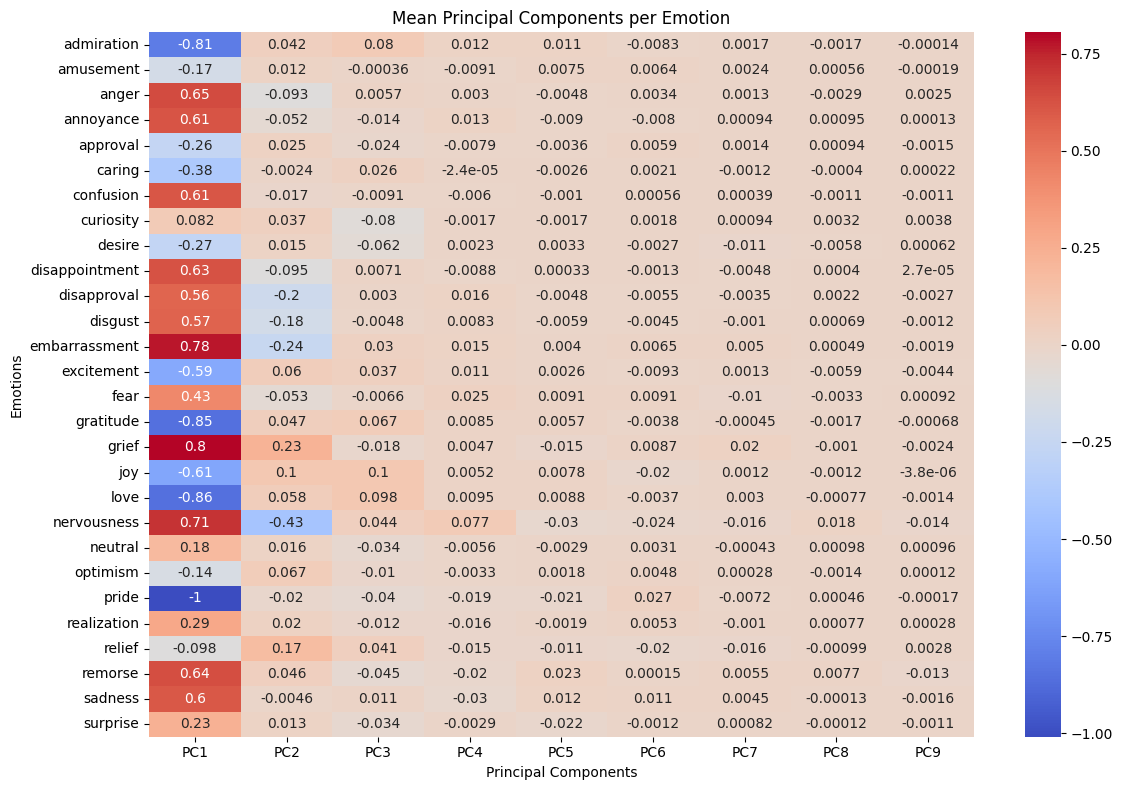

In [19]:
plt.figure(figsize=(12, 8))
sns.heatmap(mean_pcs, cmap='coolwarm', annot=True)
plt.title('Mean Principal Components per Emotion')
plt.xlabel('Principal Components')
plt.ylabel('Emotions')
plt.tight_layout()
plt.show()


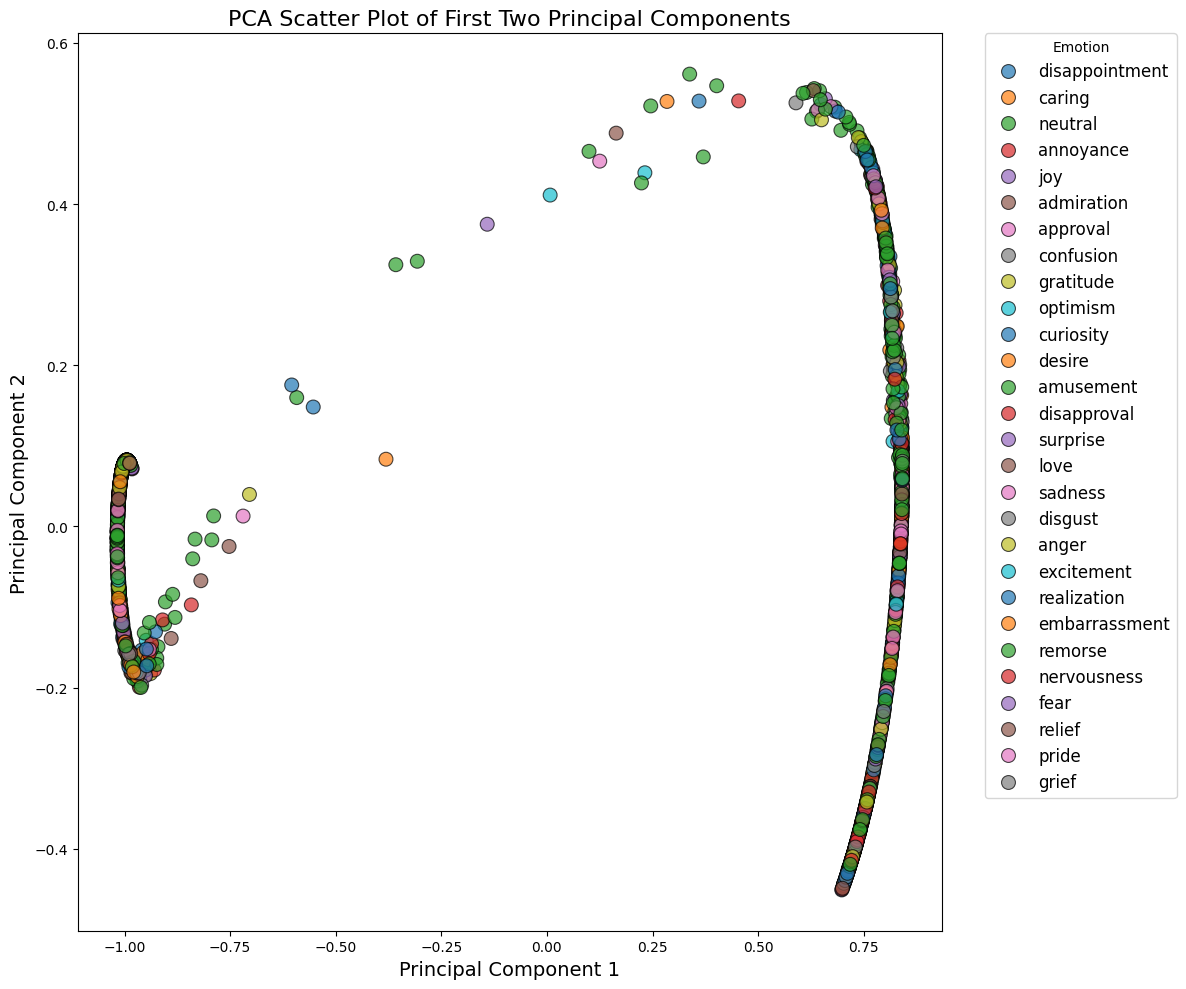

In [20]:
plt.figure(figsize=(12, 10))

# Create the scatter plot
scatter = sns.scatterplot(
    data=pc_df,
    x='PC1',
    y='PC2',
    hue='Emotion_Name',
    palette='tab10',
    alpha=0.7,
    edgecolor='k',
    s=100  
)

plt.title('PCA Scatter Plot of First Two Principal Components', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)


plt.legend(
    title='Emotion',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0,
    fontsize=12
)

plt.tight_layout()
plt.show()


It looks like a projection of some connected object from higher dim that curves on dim=2.

In [25]:
from sklearn.decomposition import FactorAnalysis

n_factors = 30  # Or another number based on your analysis
fa = FactorAnalysis(n_components=n_factors, random_state=42)
factors = fa.fit_transform(embeddings_np)

# Create DataFrame with factors
factor_columns = [f'Factor_{i+1}' for i in range(n_factors)]
factor_df = pd.DataFrame(factors, columns=factor_columns)
factor_df['Emotion_Name'] = pc_df['Emotion_Name']


In [26]:
mean_factor = factor_df.groupby('Emotion_Name')[factor_columns].mean()

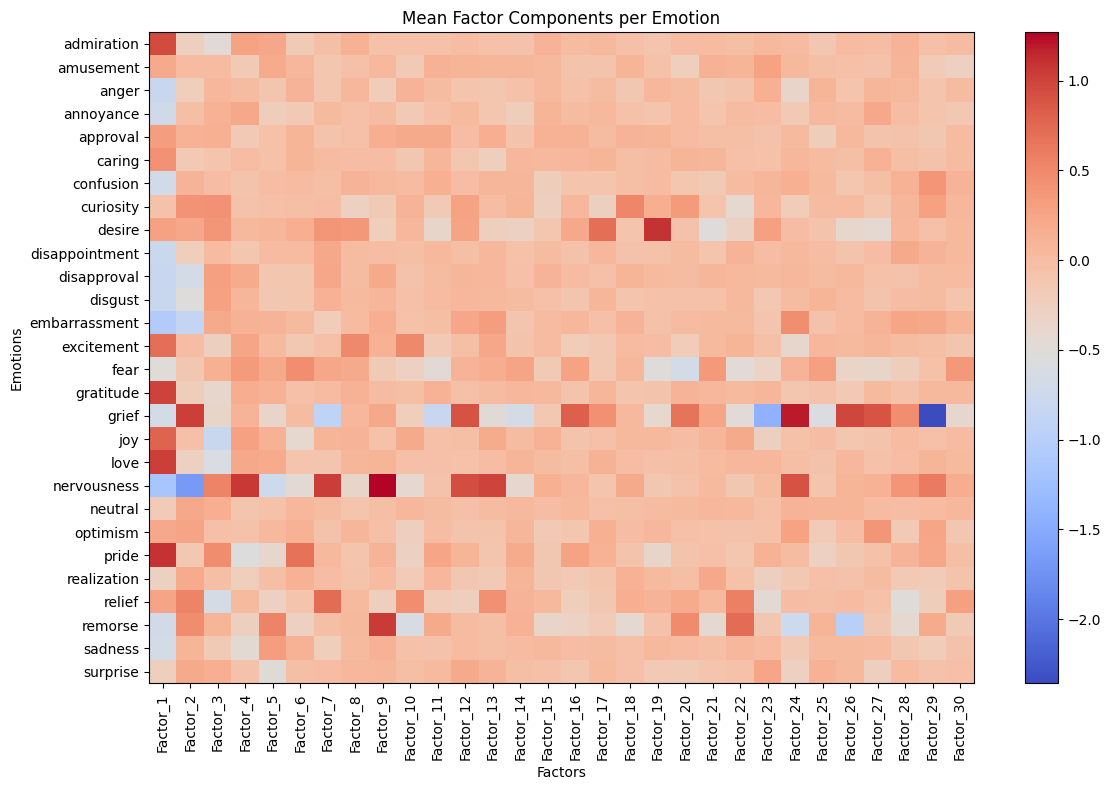

In [29]:
plt.figure(figsize=(12, 8))
plt.imshow(mean_factor.values, aspect='auto', cmap='coolwarm')
plt.xticks(ticks=np.arange(len(mean_factor.columns)), labels=mean_factor.columns, rotation=90)
plt.yticks(ticks=np.arange(len(mean_factor.index)), labels=mean_factor.index)
plt.xlabel('Factors')
plt.ylabel('Emotions')
plt.title('Mean Factor Components per Emotion')
plt.colorbar()
plt.tight_layout()
plt.show()

In [34]:
from sklearn.decomposition import KernelPCA

n_components = 9  # Number of components to keep

pca = KernelPCA(n_components=n_components,  kernel='rbf')
principal_components = pca.fit_transform(embeddings_centered)
print(f"Principal components shape: {principal_components.shape}")


Principal components shape: (2000, 9)


In [35]:
# Create a DataFrame
pc_columns = [f'PC{i+1}' for i in range(n_components)]
pc_df = pd.DataFrame(principal_components, columns=pc_columns)
pc_df['Emotion_Label'] = filtered_labels

# Get emotion names from the dataset
emotion_names = dataset['train'].features['labels'].feature.names

# Map labels to names
pc_df['Emotion_Name'] = pc_df['Emotion_Label'].apply(lambda x: emotion_names[x])
mean_pcs = pc_df.groupby('Emotion_Name')[pc_columns].mean()

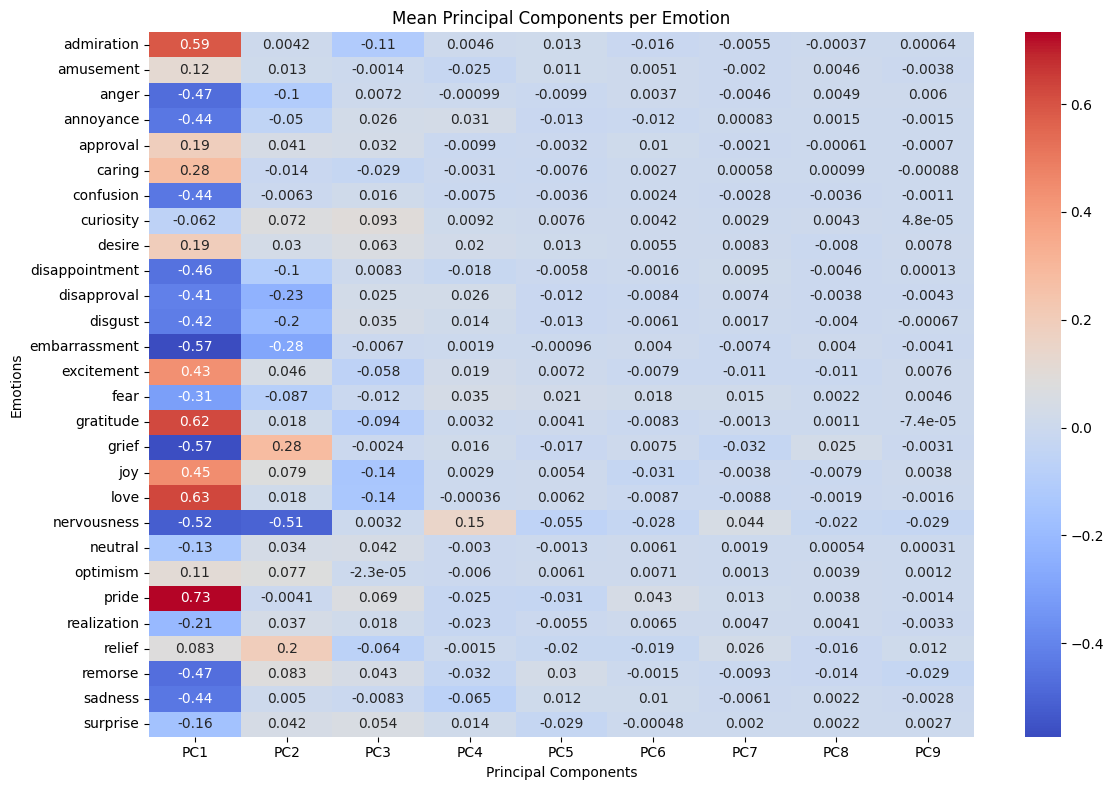

In [36]:
plt.figure(figsize=(12, 8))
sns.heatmap(mean_pcs, cmap='coolwarm', annot=True)
plt.title('Mean Principal Components per Emotion')
plt.xlabel('Principal Components')
plt.ylabel('Emotions')
plt.tight_layout()
plt.show()